In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import glob
from PIL import Image
import glob
all_images = []
img_size = (32, 20)
labels = []
for f in glob.glob('..\\data\\power\\**\\*.jpg', recursive=True):
    arr = f.split('\\')
    img = Image.open(f)
    img_resize = img.resize((img_size[0], img_size[1]))
    all_images.append(img_resize)
    label = float(arr[3])
    labels.append(label)

In [4]:
labels[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [5]:
len(labels)

12319

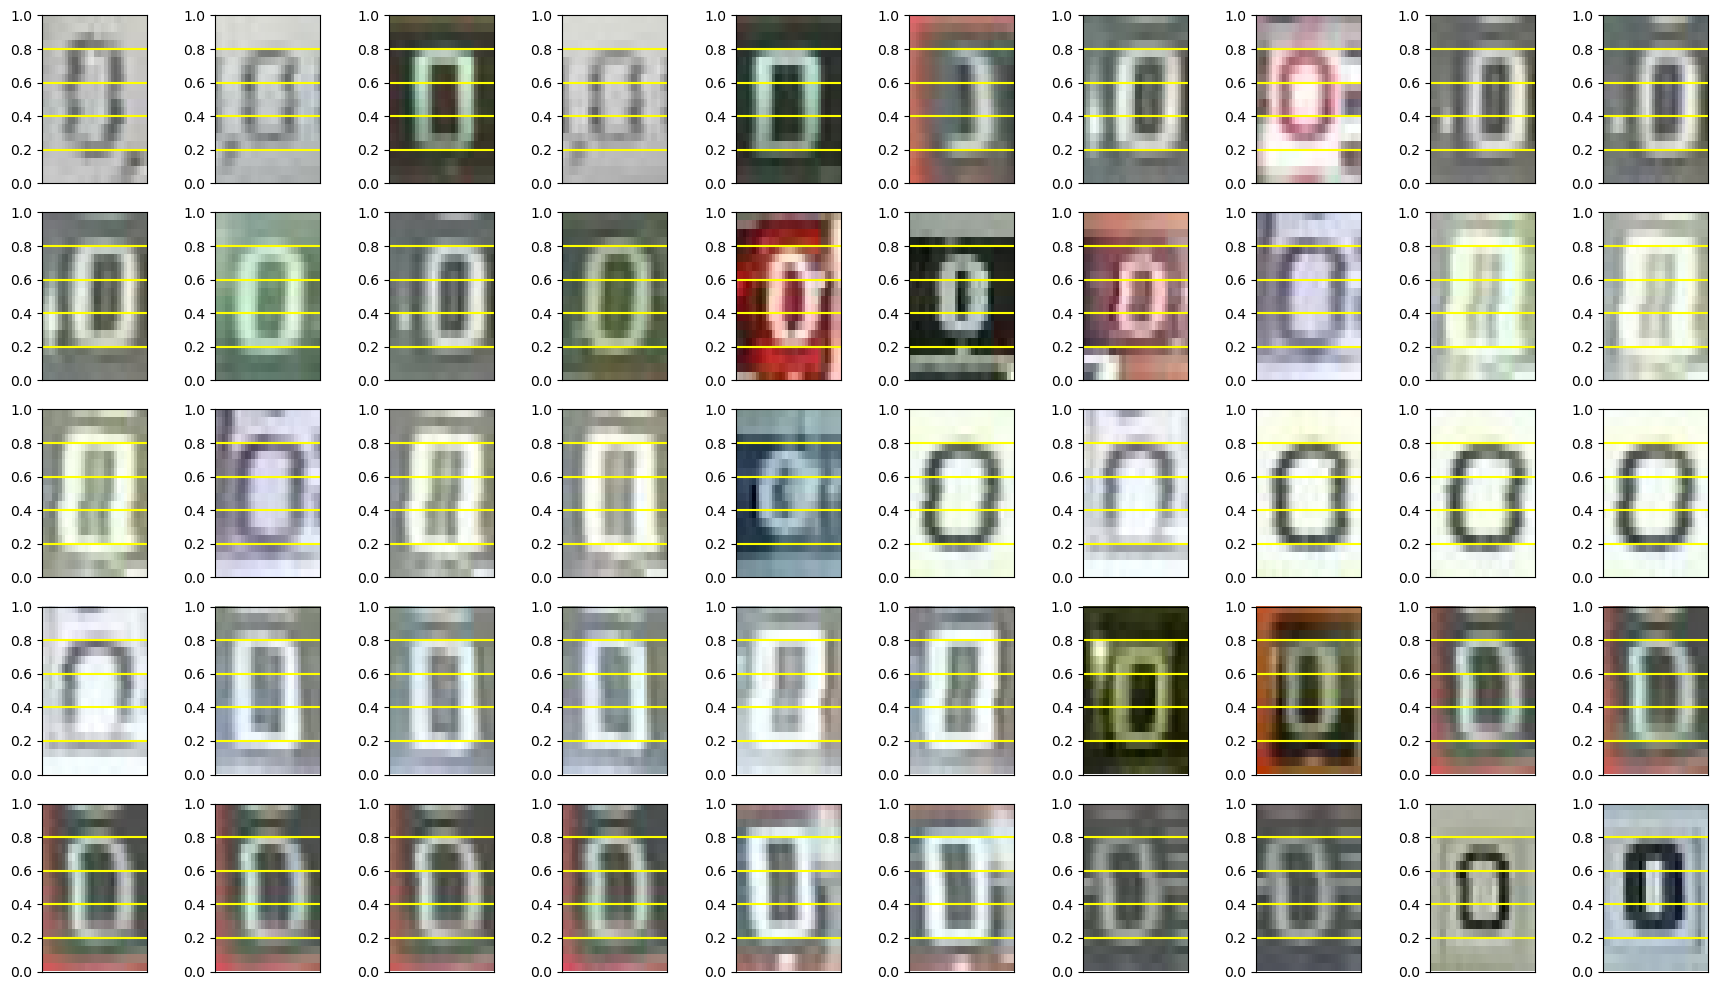

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18, 10))
columns = 10
rows = 5
for i in range(1, columns * rows +1):
    if i > len(all_images):
        break
    fig.add_subplot(rows, columns, i)
    plt.xticks([0.2, 0.4, 0.6, 0.8])
    plt.imshow((all_images[i - 1]), aspect='1.6', extent=[0, 1, 0, 1])
    for y in np.arange(0.2, 0.8, 0.2):
        plt.axhline(y=y, color='yellow')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    plt.tight_layout()

plt.show()

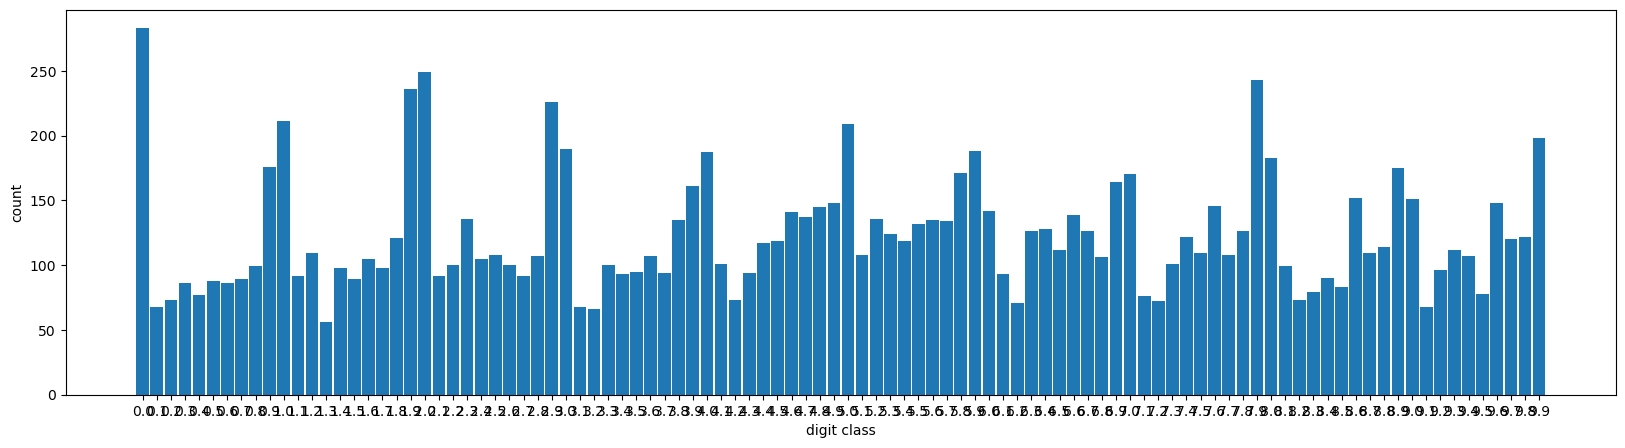

In [7]:
_, inverse = np.unique(labels, return_inverse=True)
data_bincount = np.bincount(inverse)
plt.figure(figsize=(20, 5))
plt.bar(np.arange(0, 10, 0.1), data_bincount, width=0.09, align='center')
plt.ylabel('count')
plt.xlabel('digit class')
plt.xticks(np.arange(0, 10, 0.1))
plt.show()

In [8]:
X = np.empty((1, img_size[0], img_size[1], 3))
for img in all_images:
    X = np.vstack((X, np.array(img).reshape(1, img_size[0], img_size[1], 3)))
X.shape

(12320, 32, 20, 3)

In [9]:
X = np.delete(X, (0), axis=0)

In [10]:
X.shape

(12319, 32, 20, 3)

In [11]:
x_data = X / 255.
x_data

array([[[[0.71764706, 0.72156863, 0.69803922],
         [0.71764706, 0.72156863, 0.69803922],
         [0.72156863, 0.7254902 , 0.70196078],
         ...,
         [0.78823529, 0.79215686, 0.76862745],
         [0.81960784, 0.82352941, 0.8       ],
         [0.80392157, 0.80784314, 0.78431373]],

        [[0.8       , 0.80392157, 0.78039216],
         [0.81176471, 0.81568627, 0.79215686],
         [0.77647059, 0.78039216, 0.75686275],
         ...,
         [0.74117647, 0.74509804, 0.72156863],
         [0.74509804, 0.74901961, 0.7254902 ],
         [0.75686275, 0.76078431, 0.7372549 ]],

        [[0.77647059, 0.78039216, 0.75686275],
         [0.79215686, 0.79607843, 0.77254902],
         [0.80392157, 0.80784314, 0.78431373],
         ...,
         [0.78823529, 0.78823529, 0.76078431],
         [0.8       , 0.8       , 0.76862745],
         [0.80392157, 0.80392157, 0.77254902]],

        ...,

        [[0.78431373, 0.78431373, 0.78431373],
         [0.76470588, 0.76470588, 0.76470588]

In [12]:
y_data = np.array(labels)
y_data

array([0. , 0. , 0. , ..., 9.9, 9.9, 9.9])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9855, 32, 20, 3), (2464, 32, 20, 3), (9855,), (2464,))

In [14]:
from keras.models import Sequential
from keras.layers import *

model = Sequential()
model.add(BatchNormalization(input_shape=(32, 20, 3))) # 미니 배치의 출력값을 정규화
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation= None))
model.compile(loss='mae', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 20, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 20, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 10, 32)        0         
                                                        

In [15]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("../models/power_best.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
hist = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=40, callbacks=[checkpoint])

Epoch 1/40
247/247 [==============================] - ETA: 0s - loss: 2.6879 - mae: 2.6879
Epoch 1: val_loss improved from inf to 3.82395, saving model to ../models\power_best.h5
247/247 [==============================] - 6s 12ms/step - loss: 2.6879 - mae: 2.6879 - val_loss: 3.8240 - val_mae: 3.8240
Epoch 2/40
246/247 [============================>.] - ETA: 0s - loss: 2.2386 - mae: 2.2386
Epoch 2: val_loss improved from 3.82395 to 2.05059, saving model to ../models\power_best.h5
247/247 [==============================] - 2s 10ms/step - loss: 2.2391 - mae: 2.2391 - val_loss: 2.0506 - val_mae: 2.0506
Epoch 3/40
242/247 [============================>.] - ETA: 0s - loss: 2.0565 - mae: 2.0565
Epoch 3: val_loss improved from 2.05059 to 1.77976, saving model to ../models\power_best.h5
247/247 [==============================] - 3s 10ms/step - loss: 2.0618 - mae: 2.0618 - val_loss: 1.7798 - val_mae: 1.7798
Epoch 4/40
246/247 [============================>.] - ETA: 0s - loss: 1.9343 - mae: 1.934

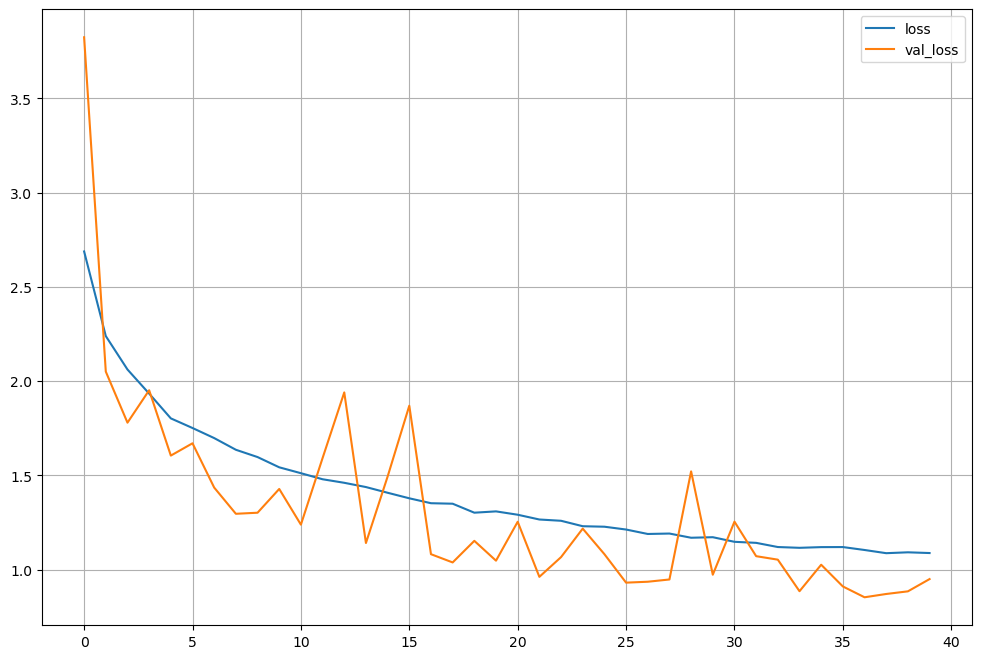

In [16]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [17]:
from tensorflow.keras.models import load_model

model = load_model('../models/power_best.h5')
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)

308/308 [==============================] - 1s 3ms/step - loss: 0.7291 - mae: 0.7291
[0.7290588021278381, 0.7290588021278381]


In [18]:
model = load_model('../models/power_best.h5')
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

77/77 [==============================] - 0s 2ms/step - loss: 0.8441 - mae: 0.8441
[0.8441217541694641, 0.8441217541694641]


In [19]:
pred=model.predict(X_test)
pred[:5]

77/77 [==============================] - 0s 2ms/step


array([[4.4308844 ],
       [6.801787  ],
       [3.3629322 ],
       [3.819672  ],
       [0.02469492]], dtype=float32)

In [20]:
y_test[:5]

array([5.8, 8.1, 4. , 8. , 0.2])